<a href="https://colab.research.google.com/github/CaptainAmu/FrameDiff/blob/master/SO3_diffusion_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this notebook use ```so3_diff.yaml```.

# SO(3) diffusion modeling and the IGSO(3) distribution
The purpose of this notebook is to provide a minimal example of a score-based generative modeling approach on the SO(3) manifold.


Key features include:
* Illustration of the agreement between the IGSO(3) density and the geodesic random walk, and their convergence to the uniform distribution on SO(3).
* Illustration of the agreement between forward and reverse processes that target a discrete measure on SO(3), for which the stein score may be computed directly by automatic differentiation (rather than estimated by score matching)
* An implementation of the isotropic Gaussian on $SO(3)$ (IGSO3) with variance parameter rescaled to agree with the Brownian motion as defined for the canonical inner product on the Lie algebra of $SO(3)$.

This notebook was written by Brian L. Trippe, Valentin de Bortoli, Jason Yim and Emile Mathieu.


In [3]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

## First define primative operations on the SO(3) manifold

In [ ]:
# Orthonormal basis of SO(3) with shape [3, 3, 3]
basis = torch.tensor([
    [[0.,0.,0.],[0.,0.,-1.],[0.,1.,0.]],
    [[0.,0.,1.],[0.,0.,0.],[-1.,0.,0.]],
    [[0.,-1.,0.],[1.,0.,0.],[0.,0.,0.]]])  # the basis for the Lie algebra so(3)

def hat(v): 
    '''
    Hat map from R^3 (rotation vector) to so(3) Lie algebra. The lie algebra isomorphism uses the canonical basis of so(3).
    Args:
        v: [..., 3] rotation vector(s)
    Returns:
        hat(v): [..., 3, 3] skew-symmetric matrix(ces)
    '''
    return torch.einsum('...i,ijk->...jk', v, basis)  # output[..., j, k] = sum_i v[..., i] * basis[i, j, k]

def Log(R): 
    '''
    Log map from SO(3) to R^3 (rotation vector).
    Args:
        R: [..., 3, 3] rotation matrix(es)
    Returns:
        v: [..., 3] rotation vector(s)
    '''
    return torch.tensor(Rotation.from_matrix(R.numpy()).as_rotvec())

def Log_stab(R):
    '''
    Log_stab map from SO(3) to R^3 (rotation vector) using only torch operations.
    (Stablized version of Log to avoid numerical issues near 0 and pi angles)
    Args:
        R: [..., 3, 3] rotation matrix(es)
    Returns:
        v: [..., 3] rotation vector(s)
    '''
    cos_omega = (R[..., 0, 0] + R[..., 1, 1] + R[..., 2, 2] - 1) / 2
    omega = torch.acos(torch.clamp(cos_omega, -1 + 1e-7, 1 - 1e-7))
    log_R = (omega[..., None, None] / (2 * torch.sin(omega[..., None, None]) + 1e-8)) * (R - R.transpose(-1, -2))
    return torch.stack([log_R[..., 2, 1], log_R[..., 0, 2], log_R[..., 1, 0]], dim=-1)


def log(R): 
    '''
    Log map from SO(3) to so(3) Lie algebra.
    Args:
        R: [..., 3, 3] rotation matrix(es)
    Returns:
        hat(Log(R)): [..., 3, 3] skew-symmetric matrix(ces)
    '''
    return hat(Log(R))

def exp(A): 
    '''
    Exponential map from so(3) Lie algebra to SO(3).
    Args:
        A: [..., 3, 3] skew-symmetric matrix(ces)
    Returns:
        exp(A): [..., 3, 3] rotation matrix(es)
    '''
    return torch.linalg.matrix_exp(A)

def expmap(R0, tangent):
    '''
    Exponential map from tangent space at R0 to SO(3).
    Args:
        R0: [..., 3, 3] rotation matrix(es)
        tangent: [..., 3, 3] tangent vector(s) at R0
    Returns:
        expmap(R0, tangent): [..., 3, 3] rotation matrix(es)
    '''
    skew_sym = torch.einsum('...ij,...ik->...jk', R0, tangent)  # Using inverse of R0 to pull tangent back to identity. and use ...ji, ...ik ->...jk.
    return torch.einsum('...ij,...jk->...ik', R0, exp(skew_sym))


def Omega(R): 
    '''
    Compute the angle of rotation from a rotation matrix.
    Args:
        R: [..., 3, 3] rotation matrix(es) (in SO(3))
    Returns:
        omega: [...] angle(s) of rotation
    '''
    return torch.arccos((torch.diagonal(R, dim1=-2, dim2=-1).sum(axis=-1)-1)/2)

## Define IGSO3 density, the geodesic random walk and check their agreement.

In [ ]:
# Power series expansion in the IGSO3 density.
def f_igso3(omega, t, L=500):
    '''
    Compute IGSO3 density.
    Args:
        omega: [...,] rotation angle(s)  
        t: [...] diffusion time
        L: [int] truncation level for the power series
    Returns:
        density: [...] IGSO3 density value(s)
    '''
    ls = torch.arange(L)[None]  # of shape [1, L]
    return ((2*ls + 1) * torch.exp(-ls*(ls+1)*t/2) *
             torch.sin(omega[:, None]*(ls+1/2)) / torch.sin(omega[:, None]/2)).sum(dim=-1)

# IGSO3(Rt; I_3, t), density with respect to the volume form on SO(3)
def igso3_density(Rt, t, L=500): 
    '''
    Compute IGSO3 density  on SO(3).
    Args:
        Rt: [..., 3, 3] rotation matrix(es) (in SO(3))
        t: [...] diffusion time
        L: [int] truncation level for the power series
    Returns:
        density: [...] IGSO3 density value(s)
    '''
    return f_igso3(Omega(Rt), t, L)

def angle_density_unif(omega):
    '''Marginal density of rotation angle for the uniform Haar density on SO(3).'''
    return (1-torch.cos(omega))/np.pi

# Normal sample in tangent space at R0
def tangent_gaussian(R0): 
    '''
    Sample a Gaussian uniform tangent vector from a Gaussian distribution in the tangent space at R0.
    Note the tangent vector at R0 is obtained by a tangent vector at I_3 multiplied by R0.
    Args:
        R0: [..., 3, 3] rotation matrix(es) (in SO(3))
    Returns:
        tangent_vector: [..., 3, 3] tangent vector(s) at R0
    '''
    return torch.einsum('...ij,...jk->...ik', R0, hat(torch.randn(R0.shape[0], 3)))  # first samples abc normally, then maps to [[0,-c,b],[c,0,-a],[-b,a,0]] @ R0

# Simluation procedure for forward and reverse
def geodesic_random_walk(p_initial, drift, ts):
    '''
    Generate 1 geodesic random walk on SO(3), starting with p_initial() sampled at ts[0], 
    and using drift(Rt, t) as the drift function, tangent_gaussian(Rt) as the noise function.

    Args:
        p_initial: function that returns [..., 3, 3] rotation matrix(es) sampled at initial time ts[0]
        drift: function that takes in (Rt, t) and returns [..., 3, 3] tangent vector(s) at Rt
        ts: [1D array] time discretization points
    Returns:
        Rts: dict mapping from time t to [..., 3, 3] rotation matrix(es) at time t
    '''
    Rts = {ts[0]:p_initial()}  # initial sample a SO(3) at ts[0]=0.
    for i in range(1, len(ts)):
        dt = ts[i] - ts[i-1] # negative for reverse process
        Rts[ts[i]] = expmap(Rts[ts[i-1]],
            drift(Rts[ts[i-1]], ts[i-1]) * dt  # drift term, in tangent space. The drift will be a NeuralNet...
            + tangent_gaussian(Rts[ts[i-1]]) * np.sqrt(abs(dt)))  # noise term, in tangent space
    return Rts


The shape of random_walk[ts[4]] (at time 0.1) is torch.Size([5000, 3, 3]).


In [24]:
# Simulate a geodesic random walk with no drift at all.  
# The following creates a dictionary random_walk, indexed by time point, 
# each random_walk[ts[t_idx]] contains N SO(3) samples.
N = 5000 # Number of samples
T = 5. # Final time
ts = np.linspace(0, T, 200) # Discretization of [0, T]
random_walk = geodesic_random_walk(
    p_initial=lambda: exp(torch.zeros(N, 3, 3)), 
    drift=lambda Rt, t: 0., 
    ts=ts)
print(f'The shape of random_walk[ts[4]] (at time {ts[4]:0.01f}) is {random_walk[ts[0]].shape}.')  # Should be (N, 3, 3)

The shape of random_walk[ts[4]] (at time 0.1) is torch.Size([5000, 3, 3]).


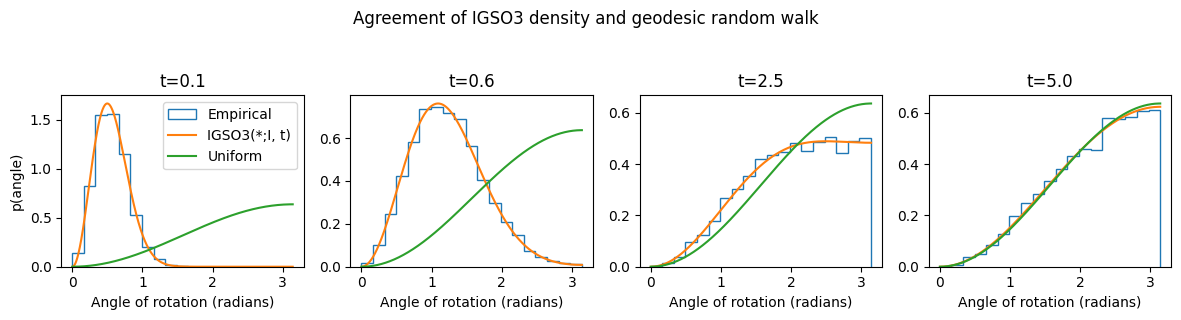

In [ ]:
t_idcs_plot = [5, 25, 100, -1]  # time indices to plot
_, axs = plt.subplots(1, len(t_idcs_plot), dpi=100, figsize=(3*len(t_idcs_plot), 3))
for i, t_idx in enumerate(t_idcs_plot):
  # Plot empirical distribution of angle of rotation from the simulated geodesic random walk
  bins = np.linspace(0, np.pi, 20)
  axs[i].hist(Omega(random_walk[ts[t_idx]]), bins=bins, density=True, histtype='step', label='Empirical')
  axs[i].set_title(f"t={ts[t_idx]:0.01f}")

  # Compute density on angle of rotation, and the density for the uniform distribution
  omega_grid = torch.linspace(0, np.pi, 1000)
  pdf_angle = f_igso3(omega_grid, ts[t_idx])*angle_density_unif(omega_grid)   # Multiply due to change of measure from SO(3) to angle
  axs[i].plot(omega_grid, pdf_angle.numpy(), label="IGSO3(*;I, t)")
  axs[i].plot(omega_grid, angle_density_unif(omega_grid).numpy(), label="Uniform")

  axs[i].set_xlabel("Angle of rotation (radians)")
axs[0].legend()
axs[0].set_ylabel("p(angle)")

plt.suptitle("Agreement of IGSO3 density and geodesic random walk", y=1.05)
plt.tight_layout()
plt.show()

Notice that the geodesic random walk and IGSO(3) density closely agree, and that by `t=5.0`, both have nearly converged to the uniform distribution on SO(3). (the distribution of angle of rotation agreed at this time point!)

# Define toy target, intermediate and invariant densities:
* Target $p_0(\cdot)=N_{\mathrm{atoms}}^{-1}\sum_{n=1}^{N_{\mathrm{atoms}}} \delta_{R_n}(\cdot),$ where each $\delta_R$ is as Dirac mass on an arbitrary, fixed rotation $R_n.$
* Invariant $p_{\mathrm{inv}}(\cdot)=\mathcal{U}_{SO(3)}(\cdot)$
* Intermediate $p_t(\cdot) = N_{\mathrm{atoms}}^{-1} \sum_{n=1}^{N_{\mathrm{atoms}}} p_{t|0}(\cdot | R_n)$  score of the noised distribution for each `t`, and the geodesic random walk for sampling for the forward and reverse processes.

And additionally define the score, $\nabla_R \log p_t(R)$ for each $t$ and $R$ using automatic differentiation.

<span style='color:orange'> I believe for sampling below </span> ```p_inv``` <span style='color:orange'> you could directly use Gram Schmidt orth of matrix with iid Gaussian entries. </span>.

In [28]:
# Sample N times from U(SO(3)) by inverting CDF of uniform distribution of angle
def p_inv(N, M=1000):
    '''
    Sample N rotation matrices from the uniform distribution on SO(3).
    Args:
        N: [int] number of samples
        M: [int] number of grid points for inverting CDF
    Returns:
        samples: [N, 3, 3] rotation matrices sampled from U(SO(3))
    '''
    omega_grid = torch.linspace(0, np.pi, M)
    cdf = np.cumsum(angle_density_unif(omega_grid).numpy())/(M/np.pi)
    omegas = np.interp(np.random.rand(N), cdf, omega_grid)
    axes = np.random.randn(N, 3)
    axes = omegas[:, None]* axes/np.linalg.norm(axes, axis=-1, keepdims=True)
    return exp(hat(torch.tensor(axes)))

## Define discrete target measure on SO(3), and its score for t>0
N_atoms = 3
mu_ks = p_inv(N_atoms) # Atoms defining target measure

# Sample p_0 ~ (1/N_atoms)\sum_k Dirac_{mu_k}
def p_0(N): 
    '''
    Sample N rotation matrices from the discrete target measure mu_ks.
    Args:
        N: [int] number of samples
    Returns:
        samples: [N, 3, 3] rotation matrices sampled from the discrete target measure mu_ks.
    '''
    return mu_ks[torch.randint(mu_ks.shape[0], size=[N])]

# Density of discrete target noised for time t
def p_t(Rt, t): 
    '''
    Compute the density of the discrete target measure at rotation matrix Rt for time t.
    Args:
        Rt: [..., 3, 3] rotation matrix(es) (in SO(3))
        t: [...] diffusion time
    Returns:
        density: [...] density value(s)
    '''
    return sum([
        igso3_density(torch.einsum('ji,...jk->...ik', mu_k, Rt), t)  # density at Rt of IGSO3(mu_k, t) is igso3_density(mu_k^T @ Rt, t), then weighted average
        for mu_k in mu_ks])/N_atoms

# Riemannian gradient of f at R using automatic differentiation
def riemannian_gradient(f, R):
    '''
    Compute the Riemannian gradient of function f at rotation matrix R.
    Args:
        f: function taking in [..., 3, 3] rotation matrix(es) and returns [...] scalar(s)
        R: [..., 3, 3] rotation matrix(es) (in SO(3))
    Returns:
        riemannian_gradient: [..., 3, 3] tangent vector(s) at R
    '''
    coefficients = torch.zeros(list(R.shape[:-2])+[3], requires_grad=True)  # shape [..., 3] of zeros
    R_delta = expmap(R, torch.einsum('...ij,...jk->...ik', R, hat(coefficients)))  # hat(coefficients) shape [..., 3, 3] is in so(3), then move to tangent space at R by multiplying R 
    grad_coefficients = torch.autograd.grad(f(R_delta).sum(), coefficients)[0]  
    # Above constructs computation graph from input(coefficients) to output(f(R_delta).sum()), 
    # computes gradient against the input arguments, and extract gradient in coefficients (the unique input argument)
    # shape [..., 3]
    return torch.einsum('...ij,...jk->...ik', R, hat(grad_coefficients)) 

# Stein score of p_t
def score_t(Rt, t): 
    '''
    Compute the Stein score of the distribution p_t at rotation matrix Rt.
    Args:
        Rt: [..., 3, 3] rotation matrix(es) (in SO(3))
        t: [...] diffusion time
    Returns:
        score: [..., 3, 3] tangent vector(s)
    '''
    # lambda R_: torch.log(p_t(R_, t)) is the f defined as an anonymous function
    return riemannian_gradient(lambda R_: torch.log(p_t(R_, t)), Rt)
    

# Simulate the forward and reverse processes

In [31]:
forward_samples = geodesic_random_walk(
    p_initial=lambda: p_0(N), drift=lambda Rt, t: 0., ts=ts)
reverse_samples = geodesic_random_walk(
    p_initial=lambda: p_inv(N), drift=lambda Rt, t: -score_t(Rt, t), ts=ts[::-1])

# Visualize the agreement of the marginals of the forward and reverse processes at several time steps

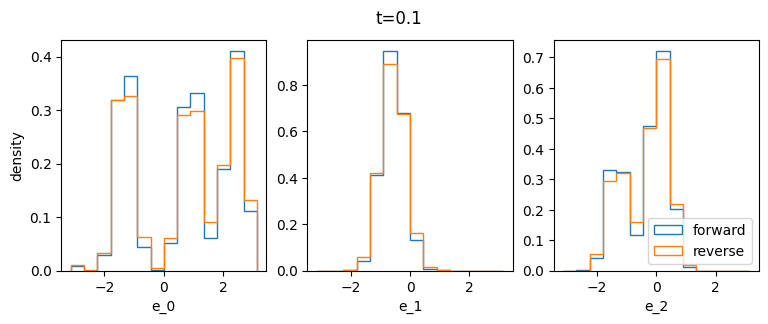

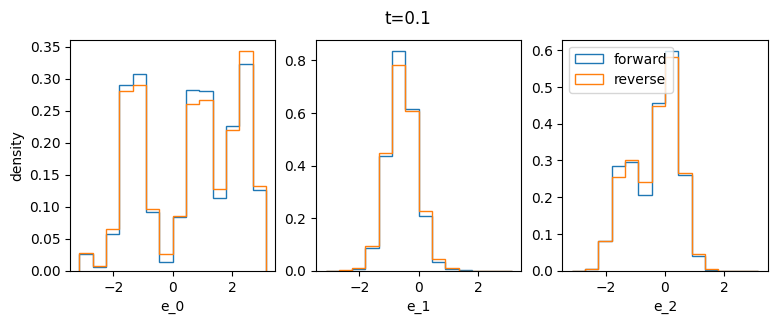

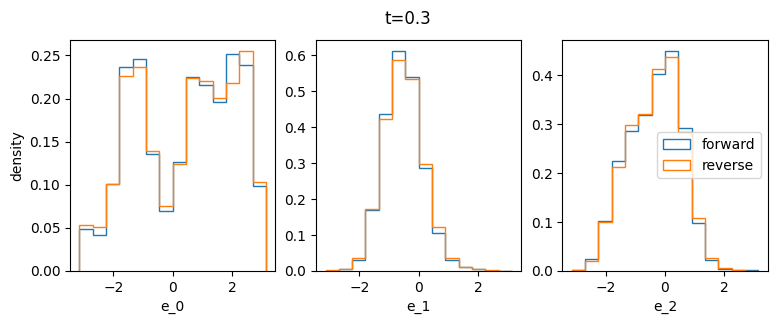

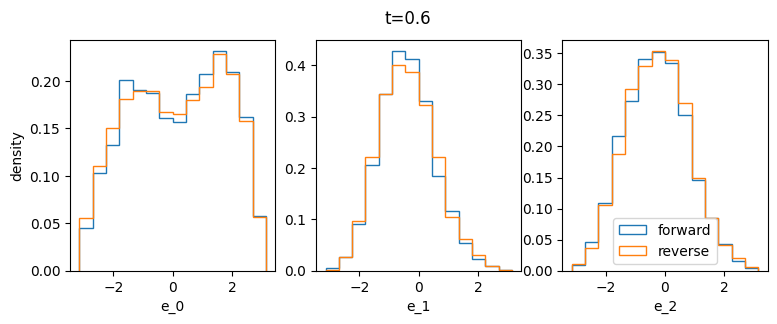

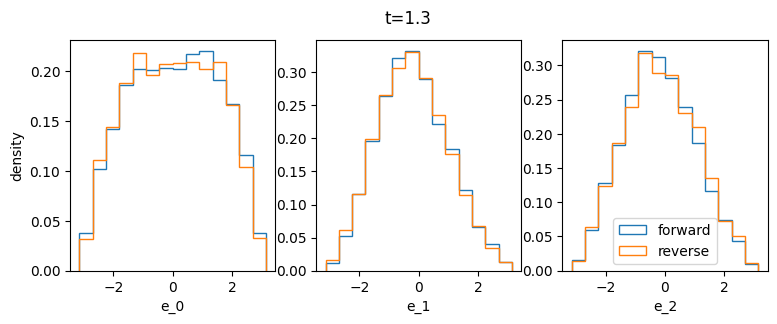

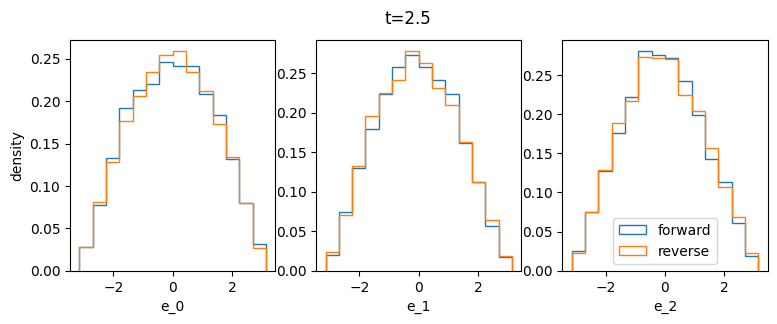

In [ ]:
# Plot comparison of forward and reverse process in orthormal basis of so(3)
for i in [3, 5, 10, 25, 50, 100]:
    t = ts[i]
    Rt_forward = Log_stab(forward_samples[ts[i]]) # instead of Log, this is stabilized version
    Rt_reverse = Log_stab(reverse_samples[ts[i]]) # instead of Log, this is stabilized version
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(9, 3))
    fig.suptitle(f't={t:.1f}')
    bins = np.linspace(-np.pi, np.pi, 15)
    for Rt, label in [(Rt_forward, "forward"), (Rt_reverse, "reverse")]:
        axs[0].set_ylabel("density")
        for i in range(3):
            axs[i].hist(Rt[:, i].numpy(), bins, density=True, histtype='step', label=label)  # distribution of the three components of Rt (in so(3) basis)
            axs[i].set_xlabel(f"e_{i}")
    plt.legend()